# Multi Yield Curve construction using Swaps and Global Optimization


Blended curve of different instruments based on their maturities and market liquidity.

&nbsp;

Sort end: cash deposits, Eurodollar futures

Long end: market swap rates


In [1]:
import QuantLib as ql
import numpy as np
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
import math
import timeit
import matplotlib.pyplot as plt

Objective: match spreadsheet 3.9 in  Swaps and Other derivatives 2nd Ed by Richard Flavell using solver optmization for the long end of the curve.

In [2]:

today = ql.Date(4, ql.February,2008)
calendar = ql.JointCalendar(ql.UnitedStates(), ql.UnitedKingdom())
ql.Settings.instance().evaluationDate = today
settle_date = calendar.advance(today, 2, ql.Days)

In [3]:
#define a Swap class to keep state of various dates and year fractions
class MySwap(object):
    def __init__(self, floating_dates, fixed_dates, fixed_rate):
        super(MySwap, self).__init__()
        self.fixed_rate = fixed_rate
        self.floating_dates = floating_dates
        self.fixed_dates = fixed_dates
        self.floating_leg_from_dates = floating_dates[:-1]
        self.floating_leg_to_dates = floating_dates[1:]
        self.fixed_leg_from_dates = fixed_dates[:-1]
        self.fixed_leg_to_dates = fixed_dates[1:]
        self.yf_floating_leg = [ql.Thirty360(ql.Thirty360.BondBasis).yearFraction(d1,d2) for d1,d2
                                in zip(self.floating_leg_from_dates,self.floating_leg_to_dates)]
        self.yf_fixed_leg = [ql.Thirty360(ql.Thirty360.BondBasis).yearFraction(d1, d2) for d1, d2
                                in zip(self.fixed_leg_from_dates, self.fixed_leg_to_dates)]
    
    # for sorting 2 swaps by maturity date   
    def __gt__(self, swap2):
        return self.floating_leg_to_dates[-1] > swap2.floating_leg_to_dates[-1]


#class for Eurodollar futures
class MyFuture(object):
    def __init__(self, begin_date, mkt_yield):
        super(MyFuture, self).__init__()
        self.begin_date = begin_date
        self.mkt_yield=  mkt_yield

#class for Cash deposits
class MyDeposit(object):
    def __init__(self, begin_date, end_date, mkt_yield):
        super(MyDeposit, self).__init__()
        self.begin_date = begin_date
        self.end_date = end_date
        self.mkt_yield=  mkt_yield
        self.yf = ql.Thirty360(ql.Thirty360.BondBasis).yearFraction(begin_date, end_date)
        self.disc_factor = 1/(1+(self.yf*mkt_yield))

# A utility function to define a vanilla IRS, specifically USD-3M-Libor 
# fixed-float swap 
def makeVanilla1Y3MSwap(maturity, fixedRate, index):
 
    end = calendar.advance(settle_date, maturity)
    fixedLegTenor = ql.Period("1y")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(settle_date,
                                end,
                                fixedLegTenor,
                                ql.TARGET(),
                                fixedLegBDC,
                                fixedLegBDC,
                                ql.DateGeneration.Forward,
                                False)
    floatSchedule = ql.Schedule(settle_date,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Forward,
                                False)
    swap = ql.VanillaSwap(ql.VanillaSwap.Payer,
                          1.0,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap

In [4]:
# A utility function to recursively calculate a series of discount factors from year fractions
# and forward rates
 
def get_disc_factors(yf, rates):
    df = [0] * len(yf)
    df[0] = 1.0 / (1.0 + (yf[0] * rates[0]))
    for i in range(1, len(yf)):
        df[i] = 1.0 / (1.0 + (yf[i] * rates[i])) * df[i - 1]
    return df

In [5]:

# this is the objective function which will be minimized using least squares method
# we calculate the par swap rate from the "guessed" forward rates 
# and minimize the difference between this par swap rate and the market quoted par swap rate
# the first 4 forward rates have been derived from deposit and Eurodollar futures and
# are known
 
#@profile
def scipy_func_to_minimize(fwdGuesses):
 
    x = np.concatenate([known_fwds,fwdGuesses])
    df_float_leg_longest_swap = get_disc_factors(swaps[-1].yf_floating_leg, x)
    
    def par_rate(yf,df):
        up = 1 - df[-1]
        down = np.sum([y*d for y,d in zip(yf,df)])
        return up/down
 
    def swap_rate(swap):
 
        df = np.interp([d.serialNumber() for d in swap.fixed_leg_to_dates],
                       [dl.serialNumber() for dl in swaps[-1].floating_leg_to_dates],
                       df_float_leg_longest_swap)
        return par_rate(swap.yf_fixed_leg, df)
 
    fi = [swap_rate(s) - s.fixed_rate for s in swaps]
    sq = smoothness_func(x)
    fi.append(sq)
    return fi

In [6]:
# This function ensures a smooth forward curve by minimizing the gradient of the 
# forward rates
# This function is added as an additional constraint to the above 
# objective function
 
def smoothness_func(fwdGuesses):
    sq = 0.0
    for i, f in enumerate(fwdGuesses[:-1]):
        sq += math.pow((fwdGuesses[i] - fwdGuesses[i + 1]), 2)
    return sq

In [7]:
# Market data as of 2/4/2008
 
libor3m = ql.USDLibor(ql.Period(3, ql.Months))
deposits = [(calendar.advance(settle_date, ql.Period(1, ql.Weeks)),0.032175),
            (calendar.advance(settle_date, ql.Period(1, ql.Months)),0.031813),
            (calendar.advance(settle_date, ql.Period(3, ql.Months)),0.03145)]
 
depos = [MyDeposit(settle_date, t[0], t[1]) for t in deposits]
 
# ED Futures start dates : Mar-08,Jun-08,Sep-08,Dec-08,Mar-09
fQuotes =   [97.000,97.410,97.520,97.495,97.395]
futures = []
 
date_holder = settle_date
for fz in fQuotes:
    fut_begin_date = ql.IMM_nextDate(date_holder)
    futures.append(MyFuture(fut_begin_date, (100.-fz)/100.))
    date_holder = fut_begin_date
 
ql_swaps = [makeVanilla1Y3MSwap(ql.Period(2, ql.Years),2.795e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(3, ql.Years),3.035e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(4, ql.Years),3.275e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(5, ql.Years),3.5050e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(6, ql.Years),3.715e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(7, ql.Years),3.885e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(8, ql.Years),4.025e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(9, ql.Years),4.155e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(10, ql.Years),4.265e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(12, ql.Years),4.435e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(15, ql.Years),4.615e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(20, ql.Years),4.755e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(25, ql.Years),4.805e-2,libor3m),
            makeVanilla1Y3MSwap(ql.Period(30, ql.Years),4.815e-2,libor3m)]
 
swaps = [MySwap([d for d in x.floatingSchedule()], [d for d in x.fixedSchedule()], x.fixedRate()) for x in ql_swaps]
swaps.sort()

In [8]:
#Starting to build fwd curve, add deposits first
 
fwd_curve = [(dep[0], dep[1]) for dep in deposits]
 
# get next 3 forward rates from futures rates by interpolating on the 
# provided rates 
 
fut_curve_dates = [calendar.advance(settle_date, ql.Period(3*i, ql.Months)) for i in range(1, 5)]
fut_interpolation = interp1d([f.begin_date.serialNumber() for f in futures], [f.mkt_yield for f in futures])
fwd_curve.extend([(fut_curve_dates[idx], fut_interpolation(fut_curve_dates[idx-1].serialNumber())[()]) 
                  for idx, f in enumerate(fut_curve_dates) if idx > 0])

In [9]:
# At this point we know first 4 forward rates 
# and we guess the next 116 forwards to be same as the 4th forward rate
known_fwds = []
for d in fut_curve_dates:
    known_fwds.extend([f[1] for f in fwd_curve if f[0] == d])
fwd_guesses = [known_fwds[-1]] * (len(swaps[-1].floating_leg_to_dates)-len(known_fwds))

In [10]:
# Now we proceed with optimization and get the optimized forwards 
# that provide the arbitrage-free and smooth forward curve

start_time = timeit.default_timer()
x = least_squares(scipy_func_to_minimize, fwd_guesses, verbose=1).x
print('### Scipy optimization took:%s seconds' % str(timeit.default_timer() - start_time))
optimized_fwds = np.concatenate([known_fwds, x])

`gtol` termination condition is satisfied.
Function evaluations 21, initial cost 1.7812e-03, final cost 1.5559e-09, first-order optimality 5.18e-09.
### Scipy optimization took:1.670270620999986 seconds


In [11]:
#Start building a discount curve as a list of tuples (date,disc_factor), 
# first discount factor = 1.0 
dates_df = [(settle_date, 1.0)]
for idx, fwd in enumerate(optimized_fwds):
    temp_tuple = (swaps[-1].floating_leg_to_dates[idx], 
                  dates_df[idx][1]/(1 + (optimized_fwds[idx] * swaps[-1].yf_floating_leg[idx])))
    dates_df.append(temp_tuple)

In [12]:
#Start building a zero curve
zc_rates = []
cumulative_floating_yf = np.cumsum(swaps[-1].yf_floating_leg)
cumulative_floating_yf = np.insert(cumulative_floating_yf, 0, 0.)
entire_date_range = swaps[-1].floating_leg_from_dates + [swaps[-1].floating_leg_to_dates[-1]]
zc_rates = [ (dt, -np.log(dc[1])/yf) for idx, (dc, yf, dt) in enumerate(zip(dates_df,cumulative_floating_yf, entire_date_range)) if idx > 0]
zc_temp_tup = (swaps[-1].floating_leg_from_dates[0], zc_rates[0][1])
zc_rates.insert(0, zc_temp_tup)

#We already have forward rates, just put them in a list of tuples

#We already have forward rates, just put them in a list of tuples
fwd_rates = [(d,fwd) for d, fwd in zip(swaps[-1].floating_leg_from_dates, optimized_fwds)]

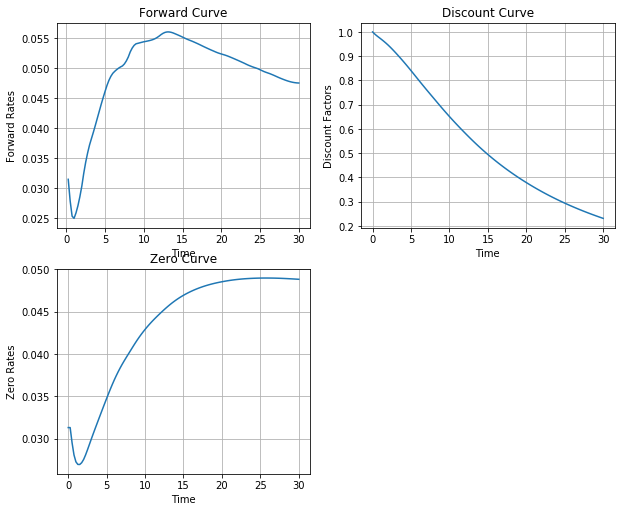

In [13]:
# Plot all 3 curves
_ = plt.figure(figsize=(10, 8.3))
 
_ = plt.subplot(221)
x_axis = cumulative_floating_yf[1:]
y_axis = list(f[1] for f in fwd_rates)
_ = plt.plot(x_axis, y_axis)
plt.grid()
_ = plt.xlabel('Time')
_ = plt.ylabel('Forward Rates')
_ = plt.title('Forward Curve')
 
_ = plt.subplot(222)
x_axis = cumulative_floating_yf
y_axis = list(d[1] for d in dates_df)
_ = plt.plot(x_axis, y_axis)
plt.grid()
_ = plt.xlabel('Time')
_ = plt.ylabel('Discount Factors')
_ = plt.title('Discount Curve')
 
_ = plt.subplot(223)
x_axis = cumulative_floating_yf
y_axis = list(z[1] for z in zc_rates)
_ = plt.plot(x_axis, y_axis)
plt.grid()
_ = plt.xlabel('Time')
_ = plt.ylabel('Zero Rates')
_ = plt.title('Zero Curve')
plt.show()